##  Volume of water and tracer mass upwelled onto the shelf

In [1]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('paper')
sns.set_style('white')

In [18]:
def plotCanyonPos(ax,UpX,DnX):
    ax.axvline(UpX,color='0.70',linestyle='--')
    ax.axvline(DnX,color='0.70',linestyle='--')
def HCW_Tracer_AlongShelf(Tr,Tr1,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
  Tr1Mask=np.ma.array(Tr1,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*Tr1Mask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

In [4]:
# Constants and scales
L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh=97.5 # head depth
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)



In [9]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc' 
CGridOut = Dataset(CGrid)

CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc' 
CGridNoCOut = Dataset(CGridNoC)

State = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
StateNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc' 

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' 
PtracersOut = Dataset(Ptracers)

Ptracers3D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run01/ptracersGlob.nc' 
PtracersOut3D = Dataset(Ptracers3D)

PtracersHD = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/ptracersGlob.nc' 
PtracersOutHD = Dataset(PtracersHD)

PtracersNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 
PtracersOutNoC = Dataset(PtracersNoC)

PtracersNoCHD = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run40/ptracersGlob.nc' 
PtracersOutNoCHD = Dataset(PtracersNoCHD)


In [6]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =22, 3D = 4, total = 19)

rc = CGridNoCOut.variables['RC']
dxf = CGridNoCOut.variables['dxF']
xc = rout.getField(CGridNoC, 'XC') # x coords tracer cells
yc = rout.getField(CGridNoC, 'YC') # y coords tracer cells

rA = rout.getField(CGridNoC, 'rA') 

drF = CGridNoCOut.variables['drF'] # vertical distance between faces
drC = CGridNoCOut.variables['drC'] # vertical distance between centers

hFacC = rout.getField(CGridNoC, 'HFacC')
mask_NoC = rout.getMask(CGridNoC, 'HFacC')



times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [10]:
Tr1 = rout.getField(Ptracers, 'Tr1')
Tr1NoC = rout.getField(PtracersNoC, 'Tr1')

Tr2 = rout.getField(Ptracers, 'Tr2')
Tr2NoC = rout.getField(PtracersNoC, 'Tr2')

Tr13D = rout.getField(Ptracers3D, 'Tr1')
Tr23D = rout.getField(Ptracers3D, 'Tr2')

Tr1HD = rout.getField(PtracersHD, 'Tr1')
Tr1NoCHD = rout.getField(PtracersNoCHD, 'Tr1')

Tr2HD = rout.getField(PtracersHD, 'Tr2')
Tr2NoCHD = rout.getField(PtracersNoCHD, 'Tr2')

In [11]:
HCW,TrMass = HCW_Tracer_AlongShelf(Tr2,Tr1,mask_NoC,29,rA,hFacC,drF,227,30,180,50)

HCWNoC,TrMassNoc = HCW_Tracer_AlongShelf(Tr2NoC,Tr1NoC,mask_NoC,29,rA,hFacC,drF,227,30,180,50)

HCW3D,TrMass3D = HCW_Tracer_AlongShelf(Tr23D,Tr13D,mask_NoC,29,rA,hFacC,drF,227,30,180,50)
HCWHD,TrMassHD = HCW_Tracer_AlongShelf(Tr2HD,Tr1HD,mask_NoC,29,rA,hFacC,drF,227,30,180,50)

HCWNoCHD,TrMassNocHD = HCW_Tracer_AlongShelf(Tr2NoCHD,Tr1NoCHD,mask_NoC,29,rA,hFacC,drF,227,30,180,50)

tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757
tracer limit concentration is:  7.21757


In [12]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [13]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii=ii+1
    
select_rec=[0,2,10,14,5,7,17]
labels = ['Base case',
          '$10^{-3} $m$^2$s$^{-1}$',
          '$10^{-3}$, $10^{-5} $m$^2$s$^{-1}$',
          '$10^{-2}$, $10^{-5} $m$^2$s$^{-1}$',
          'Lower $N$',
          'Lower $f$',
          '$R_o=$ 
          ']
colors = ['0.4','k','k','k','0.4','0.4','0.6']
line_sty = ['-','-','--',':','--',':','-']

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run67
7 CNTDIFF_run51
8 CNTDIFF_run69
9 CNTDIFF_run71
10 3DVISC_run01
11 3DVISC_run02
12 3DVISC_run03
13 3DVISC_run04
14 3DVISC_run06
15 LOW_BF_run01
16 LOWER_BF_run01
17 LOWEST_BF_run01
18 LOWEST_BF_run03
19 LOWEST_BF_run05
20 LOWEST_BF_run07
21 LOWEST_BF_run11
22 3DVISC_run05


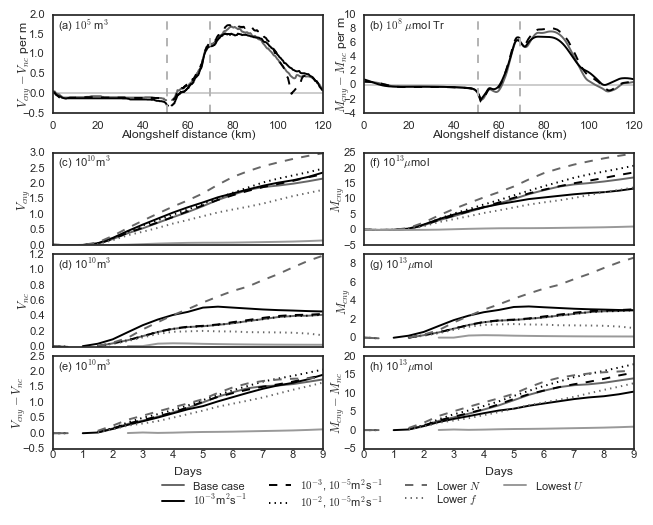

In [43]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.5,5.6)) # 190mm = 7.5in, 115cm = 4.52in

gs = gspec.GridSpec(2, 2,wspace=0.15,height_ratios=[1,3])

gs1 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1,0],hspace=0.1 )
gs2 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1,1],hspace=0.1)

ax0 = plt.subplot(gs1[0,0],xticks=[])
ax1 = plt.subplot(gs1[1,0],xticks=[])
ax2 = plt.subplot(gs1[2,0])
ax3 = plt.subplot(gs2[0,0],xticks=[])
ax4 = plt.subplot(gs2[1,0],xticks=[])
ax5 = plt.subplot(gs2[2,0])
ax6 = plt.subplot(gs[0,0])
ax7 = plt.subplot(gs[0,1])

jj = 0

for ind in select_rec:
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    ax0.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax3.plot(np.arange(0,19,1)/2.0,
             (dfcan['TrMassHCW'][0:19]-dfnoc['TrMassHCW'][0])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    
    ax1.plot(np.arange(0,19,1)/2.0,
             (dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax4.plot(np.arange(0,19,1)/2.0,
             (dfnoc['TrMassHCW'][0:19]-dfnoc['TrMassHCW'][0])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    
    ax2.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19]-dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax5.plot(np.arange(0,19,1)/2.0,
             (dfcan['TrMassHCW'][0:19]-dfnoc['TrMassHCW'][0:19])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    jj=jj+1

# -  --------------------------------------------------------------------------------------------
ii = 7
ax6.axhline(0,color='0.8')
ax6.plot(xc[1,:]/1000,(HCW[ii,:]-HCWNoC[ii,:])/(100000*dxf[0,:]),
         color='0.4',linestyle='-')
ax6.plot(xc[1,:]/1000,(HCWHD[ii,:]-HCWNoCHD[ii,:])/(100000*dxf[0,:]),
         sns.xkcd_rgb["black"],linestyle='-')
ax6.plot(xc[1,:]/1000,(HCW3D[ii,:]-HCWNoC[ii,:])/(100000*dxf[0,:]),
         sns.xkcd_rgb["black"],linestyle='--')

ax7.axhline(0,color='0.8')
ax7.plot(xc[1,:]/1000,(TrMass[ii,:]-TrMassNoc[ii,:])/(100000000*dxf[0,:]),'-',
        color='0.4')
ax7.plot(xc[1,:]/1000,(TrMassHD[ii,:]-TrMassNocHD[ii,:])/(100000000*dxf[0,:]),'-',
         color=sns.xkcd_rgb["black"])
ax7.plot(xc[1,:]/1000,(TrMass3D[ii,:]-TrMassNoc[ii,:])/(100000000*dxf[0,:]),'--',
         color=sns.xkcd_rgb["black"])

plotCanyonPos(ax6,xc[1,120]/1000,xc[1,240]/1000)
plotCanyonPos(ax7,xc[1,120]/1000,xc[1,240]/1000)


ax7.text(0.02,0.85,'(b) $10^8$ $\mu$mol Tr',transform=ax7.transAxes)    
ax6.text(0.02,0.85,'(a) $10^5$ m$^3$',transform=ax6.transAxes)

# ----------------------------------------------------------------------------------------------

ax0.text(0.02,0.85,'(c) 10$^{10}$m$^3$',transform=ax0.transAxes)
ax1.text(0.02,0.85,'(d) 10$^{10}$m$^3$',transform=ax1.transAxes)    
ax2.text(0.02,0.85,'(e) 10$^{10}$m$^3$',transform=ax2.transAxes)
ax3.text(0.02,0.85,'(f) 10$^{13}$$\mu$mol',transform=ax3.transAxes)    
ax4.text(0.02,0.85,'(g) 10$^{13}$$\mu$mol',transform=ax4.transAxes)
ax5.text(0.02,0.85,'(h) 10$^{13}$$\mu$mol',transform=ax5.transAxes)    


ax0.set_ylabel('$V_{cny}$ ',labelpad=-2)
ax1.set_ylabel('$V_{nc}$ ',labelpad=-2)
ax2.set_ylabel('$V_{cny}-V_{nc}$ ',labelpad=-3)
ax2.set_xlabel('Days')

ax3.set_ylabel('$M_{cny}$ ',labelpad=-2)
ax4.set_ylabel('$M_{cny}$ ',labelpad=-2)
ax5.set_ylabel('$M_{cny}-M_{nc}$ ',labelpad=-2)


ax5.set_xlabel('Days')

ax2.legend(bbox_to_anchor=(2,-0.2),ncol=4,labelspacing=0.1)

ax5.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax0.tick_params(axis='x', pad=0.1)
ax1.tick_params(axis='x', pad=0.1)

ax6.set_xlabel('Alongshelf distance (km)',labelpad=-1)
ax7.set_xlabel('Alongshelf distance (km)',labelpad=-1)

ax6.set_ylabel('$V_{cny}-V_{nc}$ per m',labelpad=-7)
ax7.set_ylabel('$M_{cny}-M_{nc}$ per m ',labelpad=-6)

plt.savefig('fig_HCW_TrMass_CanNoC.pdf',format='pdf',bbox_inches='tight')


In [8]:
print ("\t".join(['run name', 'Total HCW', 'CanyonHCW', 'CoastalHCW',  'Total TrMass', 'CanyonTrMass', 'CoastalTrMass']))

select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
for ind in select_rec:
    
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
  
    print ("%s\t%s" % ((records[ind].name), 
         "\t".join(['%.3e\t%.3f\t\t%.3f\t\t%.3e\t%.3f\t\t%.3f\t' % (dfcan['HCW'][18],
                                                              (dfcan['HCW'][18]-dfnoc['HCW'][18])/dfcan['HCW'][18],
                                                              dfnoc['HCW'][18]/dfcan['HCW'][18],
                                                              dfcan['TrMassHCW'][18],
                                                              (dfcan['TrMassHCW'][18]-dfnoc['TrMassHCW'][18])/dfcan['TrMassHCW'][18],
                                                              dfnoc['TrMassHCW'][18]/dfcan['TrMassHCW'][18])])))



run name	Total HCW	CanyonHCW	CoastalHCW	Total TrMass	CanyonTrMass	CoastalTrMass
CNTDIFF_run38	2.160e+10	0.807		0.193		1.704e+14	0.821		0.179	
CNTDIFF_run37	2.164e+10	0.859		0.141		1.611e+14	0.865		0.135	
CNTDIFF_run36	2.355e+10	0.805		0.195		1.344e+14	0.775		0.225	
CNTDIFF_run45	1.667e+10	0.908		0.092		1.276e+14	0.912		0.088	
CNTDIFF_run73	9.438e+09	0.895		0.105		7.098e+13	0.897		0.103	
CNTDIFF_run75	2.984e+10	0.603		0.397		2.481e+14	0.649		0.351	
CNTDIFF_run67	2.218e+10	0.782		0.218		1.758e+14	0.799		0.201	
CNTDIFF_run51	1.794e+10	0.916		0.084		1.378e+14	0.919		0.081	
CNTDIFF_run69	1.969e+10	0.871		0.129		1.532e+14	0.879		0.121	
CNTDIFF_run71	1.421e+10	0.900		0.100		1.077e+14	0.902		0.098	
3DVISC_run01	2.301e+10	0.814		0.186		1.867e+14	0.832		0.168	
3DVISC_run02	2.161e+10	0.802		0.198		1.718e+14	0.817		0.183	
3DVISC_run03	2.293e+10	0.818		0.182		1.848e+14	0.835		0.165	
3DVISC_run04	2.148e+10	0.806		0.194		1.696e+14	0.820		0.180	
3DVISC_run06	2.482e+10	0.832		0.168		2.086e+14	0.854		0.

In [17]:
print ("\t".join(['$Ro$&','$N_o$&','$\kappa_{can}$&', 'Total HCW $10^{10}$ m$^3$&', 'CanyonHCW&',  'TotTrMassHCW $10^{14}$ $\mu$Mm$^3$&', 'CanyonTrMassHCW&','TotalTrMass $10^{14}$ $\mu$Mm$^3$&', 'CanyonTrMass ' ]))

select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
for ind in select_rec:
    
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
  
    print ("\t".join(['%0.3f\t&%0.2e\t&%0.1e\t&%.3f\t&%.3f\t\t&%.3f\t\t&%.3f\t&%.3f\t\t&%.3f\t ' % (Ro(records[ind].u,
                                                                                                       records[ind].f,R),
                                                                                                    records[ind].N,
                                                                                                    records[ind].kv,
                                                                                                    dfcan['HCW'][18]/1E10,
                                                                                                    (dfcan['HCW'][18]-dfnoc['HCW'][18])/dfcan['HCW'][18],
                                                                                                    dfcan['TrMassHCW'][18]/1E14,
                                                                                                    (dfcan['TrMassHCW'][18]-dfnoc['TrMassHCW'][18])/dfcan['TrMassHCW'][18],
                                                                                                    (dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0])/1E14,
                                                                                                    (dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][18])/(dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0]))]))
                                                              



$Ro$&	$N_o$&	$\kappa_{can}$&	Total HCW $10^{10}$ m$^3$&	CanyonHCW&	TotTrMassHCW $10^{14}$ $\mu$Mm$^3$&	CanyonTrMassHCW&	TotalTrMass $10^{14}$ $\mu$Mm$^3$&	CanyonTrMass 
0.741	&0.005	&1.0e-05	&2.160	&0.807		&1.704		&0.821	&1.031		&0.313	 
0.741	&0.005	&1.0e-04	&2.164	&0.859		&1.611		&0.865	&1.048		&0.317	 
0.741	&0.005	&1.0e-03	&2.355	&0.805		&1.344		&0.775	&1.194		&0.320	 
0.741	&0.006	&1.0e-05	&1.667	&0.908		&1.276		&0.912	&0.843		&0.246	 
0.741	&0.007	&1.0e-05	&0.944	&0.895		&0.710		&0.897	&0.666		&0.169	 
0.741	&0.004	&1.0e-05	&2.984	&0.603		&2.481		&0.649	&1.379		&0.407	 
0.716	&0.005	&1.0e-05	&2.218	&0.782		&1.758		&0.799	&1.041		&0.325	 
0.932	&0.005	&1.0e-05	&1.794	&0.916		&1.378		&0.919	&0.974		&0.239	 
0.833	&0.005	&1.0e-05	&1.969	&0.871		&1.532		&0.879	&1.000		&0.273	 
1.119	&0.005	&1.0e-05	&1.421	&0.900		&1.077		&0.902	&0.929		&0.187	 
0.741	&0.005	&1.0e-03	&2.301	&0.814		&1.867		&0.832	&1.158		&0.389	 
0.741	&0.005	&1.0e-04	&2.161	&0.802		&1.718		&0.817	&1.072		&0.339	 
0.7

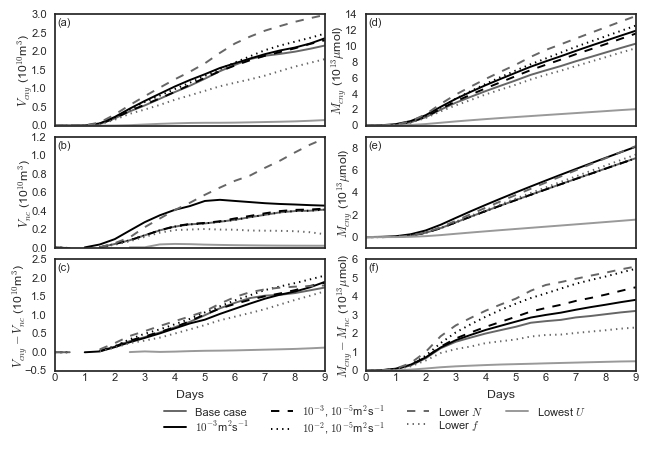

In [31]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.5,4.6)) # 190mm = 7.5in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2,wspace=0.15)
gs1 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0,0],hspace=0.1)
gs2 = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0,1],hspace=0.1)

ax0 = plt.subplot(gs1[0,0],xticks=[])
ax1 = plt.subplot(gs1[1,0],xticks=[])
ax2 = plt.subplot(gs1[2,0])
ax3 = plt.subplot(gs2[0,0],xticks=[])
ax4 = plt.subplot(gs2[1,0],xticks=[])
ax5 = plt.subplot(gs2[2,0])

jj = 0

for ind in select_rec:
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    ax0.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax3.plot(np.arange(0,19,1)/2.0,
             (dfcan['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    
    ax1.plot(np.arange(0,19,1)/2.0,
             (dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax4.plot(np.arange(0,19,1)/2.0,
             (dfnoc['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    
    ax2.plot(np.arange(0,19,1)/2.0,
             (dfcan['HCW'][0:19]-dfnoc['HCW'][0:19])/1E10,
             line_sty[jj],color=colors[jj],
             label=labels[jj])
    
    ax5.plot(np.arange(0,19,1)/2.0,
             (dfcan['TotTrMassTr1'][0:19]-dfnoc['TotTrMassTr1'][0:19])/1E13,
             line_sty[jj],
             color=colors[jj],label=labels[jj])
    jj=jj+1

ax0.text(0.01,0.90,'(a)',transform=ax0.transAxes)
ax1.text(0.01,0.90,'(b)',transform=ax1.transAxes)    
ax2.text(0.01,0.90,'(c)',transform=ax2.transAxes)
ax3.text(0.01,0.90,'(d)',transform=ax3.transAxes)    
ax4.text(0.01,0.90,'(e)',transform=ax4.transAxes)
ax5.text(0.01,0.90,'(f)',transform=ax5.transAxes)    


ax0.set_ylabel('$V_{cny}$ (10$^{10}$m$^3$)',labelpad=-2)
ax1.set_ylabel('$V_{nc}$ (10$^{10}$m$^3$)',labelpad=-2)
ax2.set_ylabel('$V_{cny}-V_{nc}$ (10$^{10}$m$^3$)',labelpad=-3)
ax2.set_xlabel('Days')

ax3.set_ylabel('$M_{cny}$ (10$^{13}$$\mu$mol)',labelpad=-2)
ax4.set_ylabel('$M_{cny}$ (10$^{13}$$\mu$mol)',labelpad=-2)
ax5.set_ylabel('$M_{cny}-M_{nc}$ (10$^{13}$$\mu$mol)',labelpad=-2)
ax5.set_xlabel('Days')

ax2.legend(bbox_to_anchor=(2,-0.2),ncol=4,labelspacing=0.1)

ax5.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)


#plt.savefig('fig_HCW_TrMass_CanNoC.eps',format='eps',bbox_inches='tight')


In [34]:
print ("\t".join(['run name', 'Total HCW', 'CanyonHCW', 'CoastalHCW',  'Total TrMass', 'CanyonTrMass', 'CoastalTrMass']))

select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
for ind in select_rec:
    
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
  
    print ("%s\t%s" % ((records[ind].name), 
         "\t".join(['%.3e\t%.3f\t\t%.3f\t\t%.3e\t%.3f\t\t%.3f\t' % (dfcan['HCW'][18],
                                                              (dfcan['HCW'][18]-dfnoc['HCW'][18])/dfcan['HCW'][18],
                                                              (dfnoc['HCW'][18])/dfcan['HCW'][18],
                                                              dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0],
                                                              (dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][18])/(dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0]),
                                                              (dfnoc['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0])/(dfcan['TotTrMassTr1'][18]-dfnoc['TotTrMassTr1'][0]))])))



run name	Total HCW	CanyonHCW	CoastalHCW	Total TrMass	CanyonTrMass	CoastalTrMass
CNTDIFF_run38	2.160e+10	0.807		0.193		1.031e+14	0.313		0.687	
CNTDIFF_run37	2.164e+10	0.859		0.141		1.048e+14	0.317		0.683	
CNTDIFF_run36	2.355e+10	0.805		0.195		1.194e+14	0.320		0.680	
CNTDIFF_run45	1.667e+10	0.908		0.092		8.429e+13	0.246		0.754	
CNTDIFF_run73	9.438e+09	0.895		0.105		6.662e+13	0.169		0.831	
CNTDIFF_run75	2.984e+10	0.603		0.397		1.379e+14	0.407		0.593	
CNTDIFF_run67	2.218e+10	0.782		0.218		1.041e+14	0.325		0.675	
CNTDIFF_run51	1.794e+10	0.916		0.084		9.739e+13	0.239		0.761	
CNTDIFF_run69	1.969e+10	0.871		0.129		9.999e+13	0.273		0.727	
CNTDIFF_run71	1.421e+10	0.900		0.100		9.293e+13	0.187		0.813	
3DVISC_run01	2.301e+10	0.814		0.186		1.158e+14	0.389		0.611	
3DVISC_run02	2.161e+10	0.802		0.198		1.072e+14	0.339		0.661	
3DVISC_run03	2.293e+10	0.818		0.182		1.158e+14	0.388		0.612	
3DVISC_run04	2.148e+10	0.806		0.194		1.071e+14	0.338		0.662	
3DVISC_run06	2.482e+10	0.832		0.168		1.259e+14	0.437		0.